# Set System Path

In [2]:
import sys
import os

sys_path = os.path.dirname(os.getcwd())
print(sys_path)
sys.path.append(sys_path)
os.chdir(sys_path)

/Users/shikaiyi/Desktop/Ncku/MedicalImage/final


# Segment Blood Vessels

In [7]:
import cv2
from retina_features.bloodvessels import extract_bv

In [3]:
pathFolder = "data/Sample_imgs/CSR"
filesArray = [x for x in os.listdir(pathFolder) if os.path.isfile(os.path.join(pathFolder,x))]
destinationFolder = "data/Sample_imgs/CSR_processed/"

In [4]:
for file_name in filesArray:
    file_name_no_extension = os.path.splitext(file_name)[0]
    fundus = cv2.imread(pathFolder + '/' + file_name)		
    bloodvessel = extract_bv(fundus)
    cv2.imwrite(destinationFolder + file_name_no_extension + "_bloodvessel.png", bloodvessel)

- 看起來 814 挺好的

# Circle CSR

In [3]:
import numpy as np
from PIL import Image
from skimage import util, exposure

from common import plot_image, compare_plots

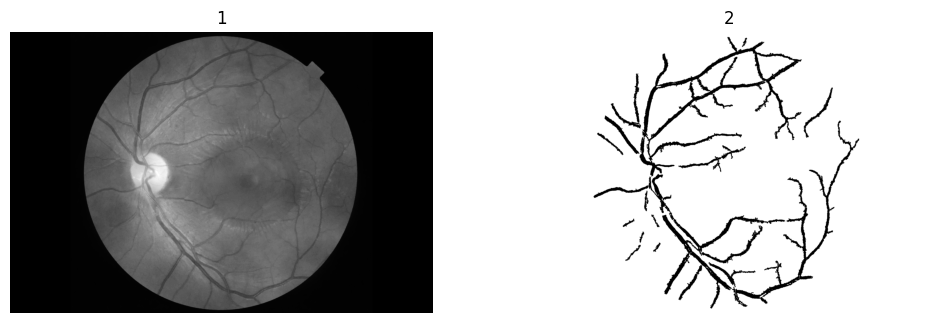

In [4]:
original_path = 'data/Sample_imgs/CSR/814.png'
original_img = Image.open(original_path)
gray_original_img = original_img.convert('L')

blood_vessel_path = 'data/Sample_imgs/CSR_processed/814_bloodvessel.png'
blood_vessel_img = Image.open(blood_vessel_path)
gray_blood_vessel_img = blood_vessel_img.convert('L')

compare_plots(gray_original_img, gray_blood_vessel_img)

In [5]:
gray_original_array = np.array(gray_original_img)
gray_blood_vessel_array = np.array(gray_blood_vessel_img)

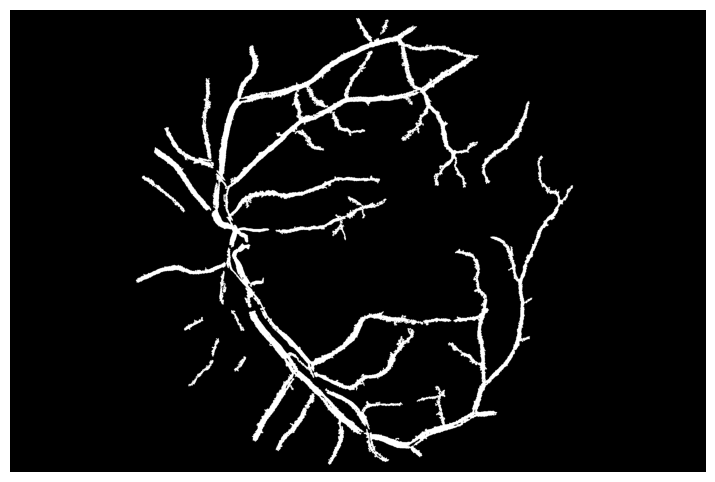

In [8]:
inpaint_mask = cv2.bitwise_not(gray_blood_vessel_array)
plot_image(inpaint_mask)

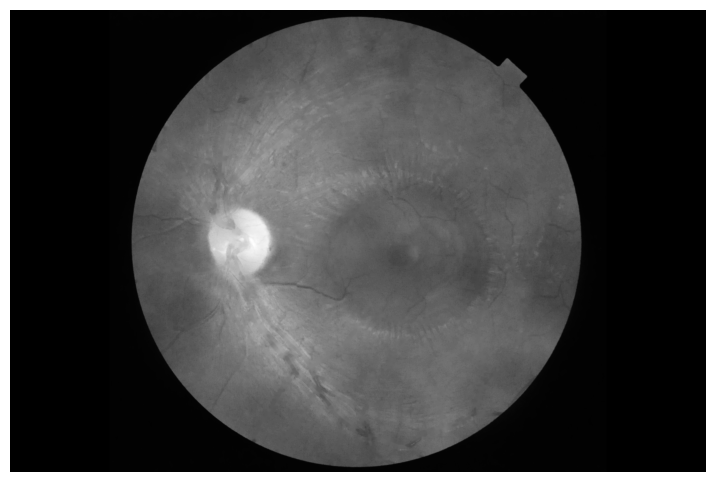

In [9]:
inpaint_radius = 3  # Radius of a circular neighborhood of each point inpainted
inpainted_img = cv2.inpaint(gray_original_array, inpaint_mask, inpaint_radius, cv2.INPAINT_TELEA)

plot_image(inpainted_img)

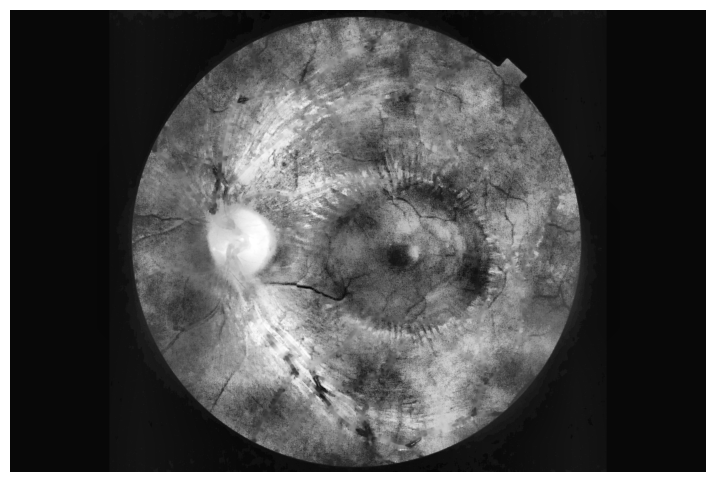

In [10]:
clahe = cv2.createCLAHE(clipLimit=8.0, tileGridSize=(8, 8))
enhanced_img = clahe.apply(inpainted_img)

enhanced_img_pil = Image.fromarray(enhanced_img)
plot_image(enhanced_img_pil)

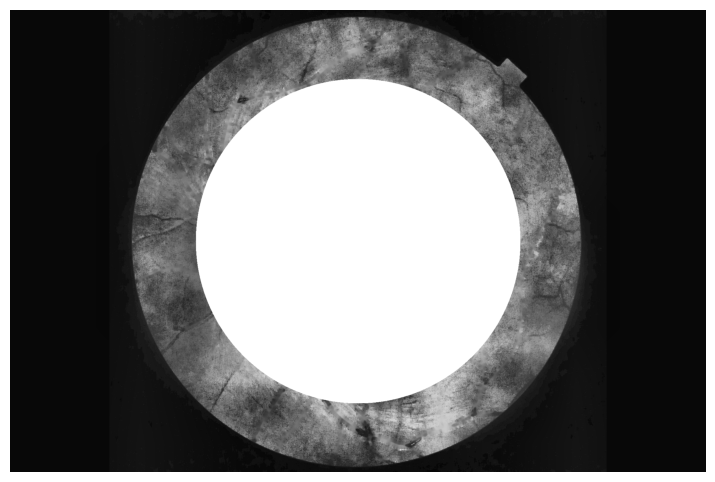

In [11]:
image_center = (original_img.size[0] // 2, original_img.size[1] // 2)
retina_mask = np.zeros_like(gray_original_img, dtype=np.uint8)
radius = 500
copy_img = enhanced_img.copy()
cv2.circle(retina_mask, image_center, radius, 255, -1)
cv2.circle(copy_img, image_center, radius, 255, -1)

plot_image(copy_img)

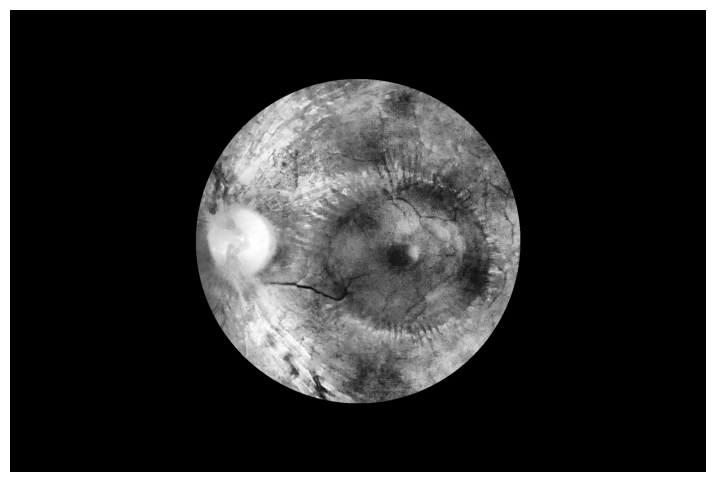

In [12]:
filtered_circle_img = cv2.bitwise_and(enhanced_img, retina_mask)
plot_image(filtered_circle_img)

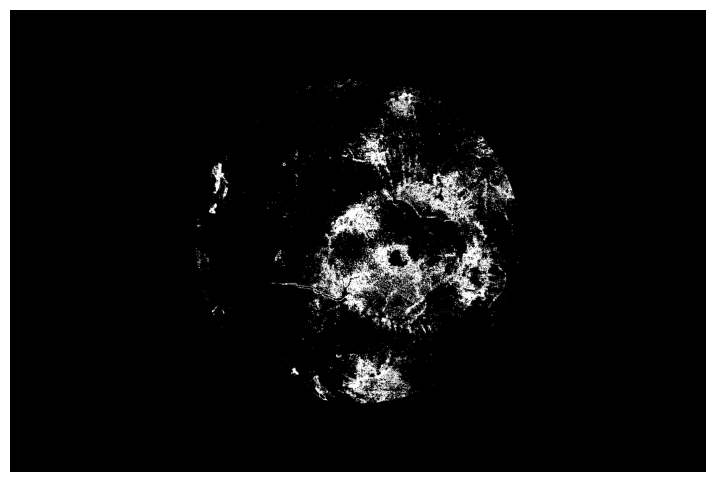

In [13]:
lighter_mask = filtered_circle_img > 40
darker_mask = filtered_circle_img < 80

# Combine both masks using a bitwise AND operation to get the final BRVO area
csr_area_mask = np.bitwise_and(lighter_mask, darker_mask)

plot_image(csr_area_mask)

In [14]:
csr_area_mask = csr_area_mask.astype(np.uint8)

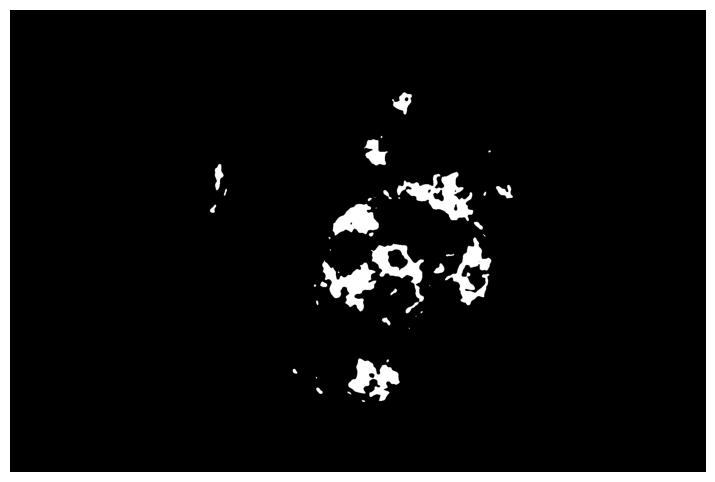

In [15]:
blurred_image = cv2.GaussianBlur(csr_area_mask, (27, 27), 0)
plot_image(blurred_image)

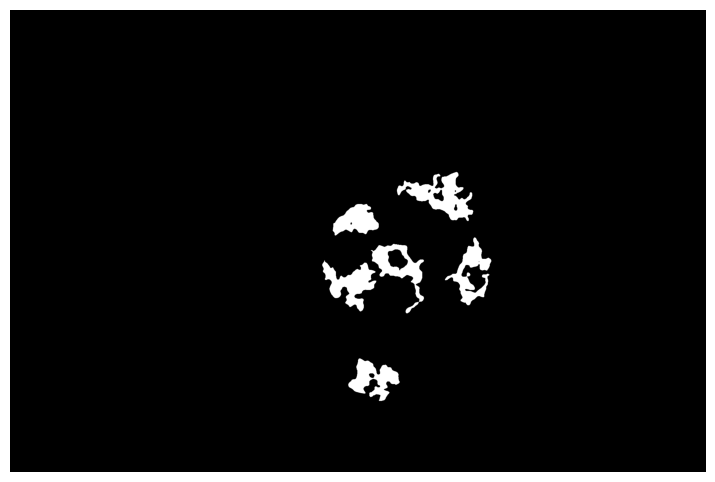

In [16]:
contours, _ = cv2.findContours(blurred_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
size_threshold = 3200 

for cnt in contours:
    if cv2.contourArea(cnt) < size_threshold:
        cv2.drawContours(blurred_image, [cnt], -1, (0), thickness=cv2.FILLED)

plot_image(blurred_image)

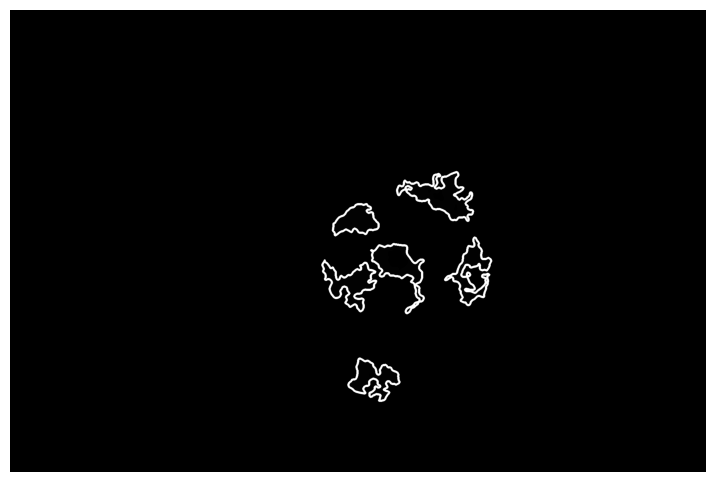

In [17]:
contours, _ = cv2.findContours(blurred_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

copy_img = blurred_image.copy()
cv2.drawContours(copy_img, contours, -1, (100), 5)

plot_image(copy_img)

In [18]:
def get_contour_center(contour):
    M = cv2.moments(contour)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        cX, cY = 0, 0
    return cX, cY

In [19]:
from sklearn.cluster import DBSCAN

def cluster_largest_cnts(contours, epsilon, min_samples):
    centers = np.array([get_contour_center(c) for c in contours])
    areas = np.array([cv2.contourArea(c) for c in contours])

    clustering = DBSCAN(eps=epsilon, min_samples=min_samples).fit(centers)
    labels = clustering.labels_

    cluster_areas = {}
    for label, area in zip(labels, areas):
        if label != -1:  # Ignore outliers
            if label in cluster_areas:
                cluster_areas[label] += area
            else:
                cluster_areas[label] = area

    if not cluster_areas:
        print("No clusters found. All contours are treated as outliers. Consider increasing 'epsilon'.")
        return []

    largest_cluster_label = max(cluster_areas, key=cluster_areas.get)
    filtered_contours = [contour for contour, label in zip(contours, labels) if label == largest_cluster_label]

    return filtered_contours

In [20]:
filtered_contours = cluster_largest_cnts(contours, 300, 5)

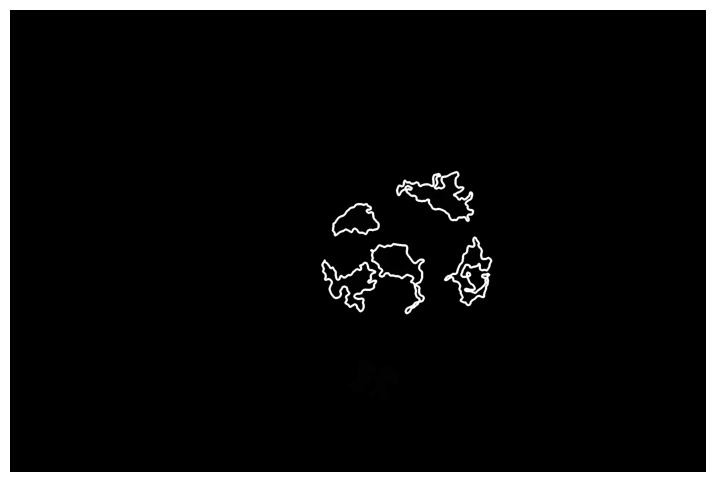

In [21]:
copy_img = blurred_image.copy()
cv2.drawContours(copy_img, filtered_contours, -1, (100), 5)

plot_image(copy_img)

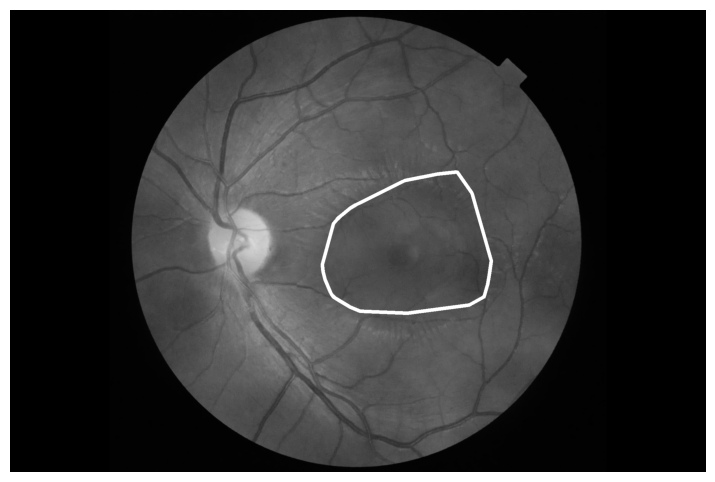

In [22]:
all_points = np.vstack(filtered_contours).squeeze()
hull = cv2.convexHull(all_points)

hull_img = gray_original_array.copy()
cv2.drawContours(hull_img, [hull], -1, (255), 10)

plot_image(hull_img)